In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from typing import List, Tuple

import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def generate_scaffolds(dataset: List,
                         log_every_n: int = 1000) -> List[List[int]]:
    """Returns all scaffolds from the dataset.
    Parameters
    ----------
    dataset: Dataset
      Dataset to be split. List of smiles
    log_every_n: int, optional (default 1000)
      Controls the logger by dictating how often logger outputs
      will be produced.
    Returns
    -------
    scaffold_sets: List[List[int]]
      List of indices of each scaffold in the dataset.
    """
    scaffolds = {}
    data_len = len(dataset)

    for ind, smiles in enumerate(dataset):
      scaffold = _generate_scaffold(smiles)
      if scaffold not in scaffolds:
        scaffolds[scaffold] = [ind]
      else:
        scaffolds[scaffold].append(ind)

    # Sort from largest to smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    scaffold_sets = [
        scaffold_set for (scaffold, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]
    return scaffold_sets

def _generate_scaffold(smiles: str, include_chirality: bool = False) -> str:
  """Compute the Bemis-Murcko scaffold for a SMILES string.
  Bemis-Murcko scaffolds are described in DOI: 10.1021/jm9602928.
  They are essentially that part of the molecule consisting of
  rings and the linker atoms between them.
  Paramters
  ---------
  smiles: str
    SMILES
  include_chirality: bool, default False
    Whether to include chirality in scaffolds or not.
  Returns
  -------
  str
    The MurckScaffold SMILES from the original SMILES
  References
  ----------
  .. [1] Bemis, Guy W., and Mark A. Murcko. "The properties of known drugs.
     1. Molecular frameworks." Journal of medicinal chemistry 39.15 (1996): 2887-2893.
  Note
  ----
  This function requires RDKit to be installed.
  """
  try:
    from rdkit import Chem
    from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
  except ModuleNotFoundError:
    raise ImportError("This function requires RDKit to be installed.")

  mol = Chem.MolFromSmiles(smiles)
  scaffold = MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)
  return scaffold

In [3]:
data_dir_path = 'data/'
pdbbind_refined_dir_path = '../PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir_path = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

In [4]:
with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list_with_h.p'), 'rb') as f :
    general_mols = pickle.load(f)
    
with open(os.path.join(data_dir_path, 'pdbbind_refined_mol_list_with_h.p'), 'rb') as f :
    refined_mols = pickle.load(f)

In [5]:
all_mols = general_mols + refined_mols

In [6]:
all_smiles = list(set([Chem.MolToSmiles(mol) for mol in all_mols]))

In [7]:
len(all_smiles)

12348

In [8]:
scaffold_sets = generate_scaffolds(all_smiles)

In [9]:
frac_train = 0.8
frac_valid = 0.1

train_cutoff = frac_train * len(all_smiles)
valid_cutoff = (frac_train + frac_valid) * len(all_smiles)
train_inds: List[int] = []
valid_inds: List[int] = []
test_inds: List[int] = []

In [10]:
for scaffold_set in scaffold_sets:
    if len(train_inds) + len(scaffold_set) > train_cutoff:
        if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
            test_inds += scaffold_set
        else:
            valid_inds += scaffold_set
    else:
        train_inds += scaffold_set

In [11]:
train_smiles = [smiles for i, smiles in enumerate(all_smiles) if i in train_inds]
valid_smiles = [smiles for i, smiles in enumerate(all_smiles) if i in valid_inds]
test_smiles = [smiles for i, smiles in enumerate(all_smiles) if i in test_inds]

In [12]:
with open('data/train_smiles_scaffold_with_h.txt', 'w') as f :
    for smiles in train_smiles :
        f.write(smiles)
        f.write('\n')
        
with open('data/valid_smiles_scaffold_with_h.txt', 'w') as f :
    for smiles in valid_smiles :
        f.write(smiles)
        f.write('\n')
        
with open('data/test_smiles_scaffold_with_h.txt', 'w') as f :
    for smiles in test_smiles :
        f.write(smiles)
        f.write('\n')

In [7]:
all_mols_unique = [Chem.MolFromSmiles(smiles) for smiles in all_smiles]

In [8]:
all_fps = [GetMorganFingerprintAsBitVect(mol, 2) for mol in all_mols_unique]

In [36]:
train_ratio = 0.6
train_size = int(train_ratio * len(all_fps))
test_size = len(all_fps) - train_size

In [37]:
train_i, test_i = split_fingerprints(all_fps, train_size, test_size)

In [38]:
train_smiles = [smiles for i, smiles in enumerate(all_smiles) if i in train_i]
test_smiles = [smiles for i, smiles in enumerate(all_smiles) if i in test_i]

train_fps = [fp for i, fp in enumerate(all_fps) if i in train_i]
test_fps = [fp for i, fp in enumerate(all_fps) if i in test_i]

In [39]:
valid_ratio = 0.2
valid_size = int(valid_ratio * len(all_fps))
test_size = len(all_fps) - train_size - valid_size

In [40]:
train_size

7409

In [41]:
valid_i, test_i = split_fingerprints(test_fps, valid_size, test_size)

In [42]:
valid_smiles = [smiles for i, smiles in enumerate(all_smiles) if i in valid_i]
test_smiles = [smiles for i, smiles in enumerate(all_smiles) if i in test_i]

valid_fps = [fp for i, fp in enumerate(all_fps) if i in valid_i]
test_fps = [fp for i, fp in enumerate(all_fps) if i in test_i]

In [50]:
with open('data/train_smiles.txt', 'w') as f :
    for smiles in train_smiles :
        f.write(smiles)
        f.write('\n')
        
with open('data/valid_smiles.txt', 'w') as f :
    for smiles in valid_smiles :
        f.write(smiles)
        f.write('\n')
        
with open('data/test_smiles.txt', 'w') as f :
    for smiles in test_smiles :
        f.write(smiles)
        f.write('\n')

In [43]:
similarity = DataStructs.BulkTanimotoSimilarity(train_fps[0], test_fps)

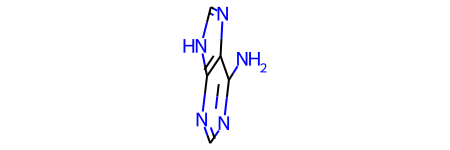

In [90]:
general_mols[10]

In [91]:
general_smiles = set([Chem.MolToSmiles(mol) for mol in general_mols])

In [93]:
general_mols_unique = [Chem.MolFromSmiles(smiles) for smiles in general_smiles]

In [94]:
general_fps = [GetMorganFingerprintAsBitVect(mol, 2) for mol in general_mols_unique]

In [95]:
sims = []
max_sim = 0
max_i = 0
max_j = 0
for i, fp1 in enumerate(general_fps) :
    for j, fp2 in enumerate(general_fps[i+1:]) :
        sim = DataStructs.TanimotoSimilarity(fp1,fp2)
        sims.append(sim)
        if sim > max_sim :
            max_sim = sim
            max_i = i
            max_j = i + 1 + j

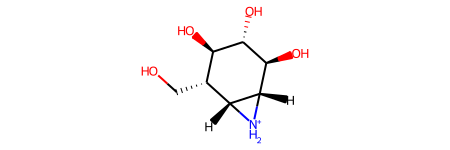

In [96]:
general_mols_unique[max_i]

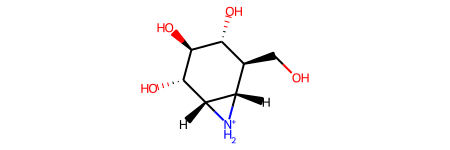

In [97]:
general_mols_unique[max_j]

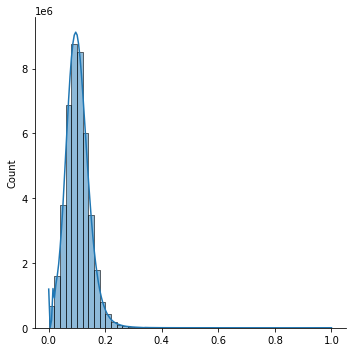

In [98]:
sns.displot(sims, bins=50, kde=True)

In [92]:
from deepchem.feat import CircularFingerprint

featurizer = CircularFingerprint()
ecfp = featurizer.featurize(general_smiles)
ecfp.shape

(9288, 2048)

In [10]:
with open(os.path.join(data_dir_path, 'pdbbind_refined_mol_list.p'), 'rb') as f :
    refined_mols = pickle.load(f)

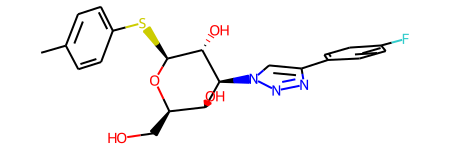

In [11]:
refined_mols[2]

In [12]:
refined_smiles = set([Chem.MolToSmiles(mol) for mol in refined_mols])

In [13]:
refined_fps = [GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2) for smiles in refined_smiles]

In [14]:
len(refined_fps)

3606

In [15]:
sims = []
for i, fp1 in enumerate(refined_fps) :
    for fp2 in refined_fps[i+1:] :
        sims.append(DataStructs.TanimotoSimilarity(fp1,fp2))

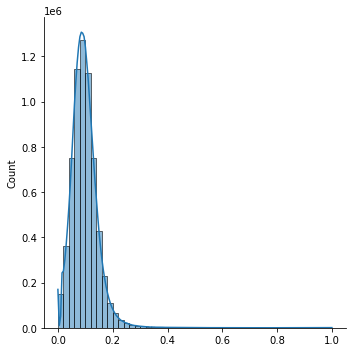

In [16]:
sns.displot(sims, bins=50, kde=True)

In [10]:
import numpy as np
hist, bin_edges = np.histogram(sims, bins=50)

In [25]:
hist

array([ 659727, 1594754, 3794984, 6876414, 8751860, 8510110, 6024450,
       3467283, 1782216,  803479,  427731,  188726,   97785,   51719,
         29340,   18654,   11128,    7655,    5643,    3766,    3437,
          2544,    2122,    1721,    1261,    1547,    1197,     923,
           845,     687,     797,     564,     545,     434,     442,
           357,     376,     308,     269,     189,     168,     118,
            98,      66,      56,      25,      13,      16,      17,
           262])

In [20]:
bin_edges.shape

(51,)

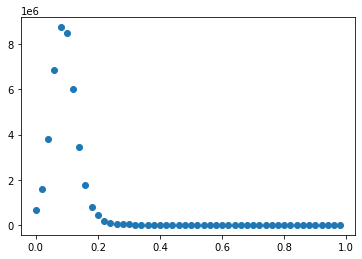

In [27]:
plt.scatter(bin_edges[:50], hist)

<BarContainer object of 50 artists>

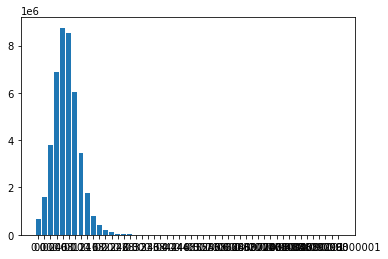

In [26]:
plt.bar([str(v) for v in bin_edges[:50]], hist)

(array([1.65290e+04, 3.70230e+04, 9.15620e+04, 1.58470e+05, 2.01046e+05,
        1.95808e+05, 1.37761e+05, 7.99700e+04, 4.17590e+04, 1.90280e+04,
        1.04370e+04, 4.54600e+03, 2.33100e+03, 1.35100e+03, 7.62000e+02,
        4.47000e+02, 2.66000e+02, 1.96000e+02, 1.12000e+02, 9.00000e+01,
        7.30000e+01, 5.40000e+01, 4.80000e+01, 4.40000e+01, 3.80000e+01,
        3.90000e+01, 4.10000e+01, 2.30000e+01, 1.90000e+01, 2.60000e+01,
        2.80000e+01, 5.00000e+00, 7.00000e+00, 1.20000e+01, 6.00000e+00,
        4.00000e+00, 3.00000e+00, 7.00000e+00, 4.00000e+00, 4.00000e+00,
        1.00000e+01, 2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.

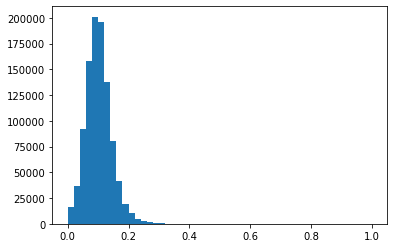

In [9]:
plt.hist(sims, bins=50)

In [18]:
sims = []
for i, fp1 in enumerate(refined_fps) :
    for fp2 in refined_fps[i+1:] :
        sims.append(DataStructs.DiceSimilarity(fp1,fp2))

In [19]:
sims[:100]

[0.17647058823529413,
 0.183206106870229,
 0.11851851851851852,
 0.22727272727272727,
 0.15503875968992248,
 0.1076923076923077,
 0.20994475138121546,
 0.13725490196078433,
 0.1411764705882353,
 0.16080402010050251,
 0.15555555555555556,
 0.2122905027932961,
 0.18604651162790697,
 0.189873417721519,
 0.07936507936507936,
 0.18055555555555555,
 0.18497109826589594,
 0.17543859649122806,
 0.20238095238095238,
 0.15714285714285714,
 0.10294117647058823,
 0.14864864864864866,
 0.14102564102564102,
 0.2236024844720497,
 0.21476510067114093,
 0.18705035971223022,
 0.23030303030303031,
 0.1206896551724138,
 0.12307692307692308,
 0.17142857142857143,
 0.1437908496732026,
 0.21965317919075145,
 0.1641025641025641,
 0.09815950920245399,
 0.16049382716049382,
 0.1702127659574468,
 0.15384615384615385,
 0.25842696629213485,
 0.16,
 0.16243654822335024,
 0.10650887573964497,
 0.1610738255033557,
 0.19148936170212766,
 0.1566265060240964,
 0.15584415584415584,
 0.16,
 0.16216216216216217,
 0.1324503

In [16]:
len(sims)

43128828

(array([1.31500e+03, 1.23040e+04, 6.14390e+04, 1.47234e+05, 2.22885e+05,
        2.32741e+05, 1.66197e+05, 8.89940e+04, 3.88270e+04, 1.51970e+04,
        6.43000e+03, 2.64800e+03, 1.33300e+03, 7.29000e+02, 4.86000e+02,
        3.06000e+02, 1.93000e+02, 1.44000e+02, 1.00000e+02, 8.20000e+01,
        5.30000e+01, 6.40000e+01, 3.20000e+01, 4.30000e+01, 3.00000e+01,
        2.30000e+01, 2.00000e+01, 1.40000e+01, 2.20000e+01, 1.80000e+01,
        1.40000e+01, 1.50000e+01, 1.00000e+01, 1.00000e+01, 7.00000e+00,
        8.00000e+00, 7.00000e+00, 3.00000e+00, 5.00000e+00, 5.00000e+00,
        4.00000e+00, 1.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.

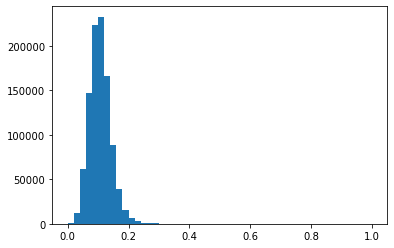

In [26]:
plt.hist(sims[:1000000], bins=50)